In [1]:
# Importieren der benötigten Bibliotheken

# Datenmanipulation
import pandas as pd
import pickle

# Visualisierung
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Warnings unterdrücken
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action="ignore", category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

# Modelling


In [2]:
# Einlesen der Trainings- und Testdaten
features_train = pd.read_csv("../data/processed/features_train.csv")
features_test = pd.read_csv("../data/processed/features_test.csv")
target_train = pd.read_csv("../data/processed/target_train.csv")
target_test = pd.read_csv("../data/processed/target_test.csv")

# Zielvariable in einem dict organisieren
targets = {
    "compressor": {
        "train": target_train.iloc[:, 0],
        "test": target_test.iloc[:, 0]
    },
    "turbine": {
        "train": target_train.iloc[:, 1],
        "test": target_test.iloc[:, 1]
    }
}

**Feature Engineering**


In [3]:
def engineer_features(df):
    '''
    - Neue Features zum DataFrame hinzufügen.

    Args:
        df (pd.DataFrame): DataFrame.

    Returns:
        pd.DataFrame: DataFrame mit zusätzlichen Features.
    '''
    
    df_engineer = df.copy()
    df_engineer["compressor_ratio"] = df["GT_Compressor_outlet_air_pressure_(P15)_[bar]"] / df["GT_Compressor_inlet_air_pressure_(P1)_[bar]"]

    return df_engineer

**Data Scaling** + **Dimensionality Reduction**


In [4]:
# Piplines für verschiedene Modelle

# Lineare Regression mit StandardScaler und PCA
pipeline_lr = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('model', LinearRegression())
])

# Random Forest Regressor
pipeline_rf = Pipeline([("model", RandomForestRegressor(random_state=42))])

# Decision Tree Regressor
pipeline_dt = Pipeline([("model", DecisionTreeRegressor(random_state=42))])

# Modelle in einem Dictionary organisieren
models = {
    "Linear Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "Decision Tree": pipeline_dt
}

**Feature Selection**


In [5]:
# features_train = engineer_features(features_train)
# features_test = engineer_features(features_test)

important_features = [
    "gt_compressor_outlet_air_temperature_t2_c",
    "gas_turbine_gt_shaft_torque_gtt_kn_m",
    "hp_turbine_exit_pressure_p48_bar",
    "gas_generator_rate_of_revolutions_ggn_rpm",
    "gt_exhaust_gas_pressure_pexh_bar",
    "gt_compressor_outlet_air_pressure_p2_bar",
    "gt_rate_of_revolutions_gtn_rpm"
]

features_train = features_train[important_features]
features_test = features_test[important_features]

**Train Model**


In [6]:
# Evaluierung der Modelle

all_results = []

# Äußere Schleife für die Zielvariablen
for target_name, target_data in targets.items():
    target_train_data = target_data["train"]
    target_test_data = target_data["test"]
    
    # Innere Schleife für die Modell-VorlagPipelines
    for model_name, model_pipeline in models.items():
        
        # Erstelle eine Kopie des Modells
        current_model = clone(model_pipeline)
        
        # Training des Modells
        current_model.fit(features_train, target_train_data)
        
        # Vorhersagen auf den Testdaten
        target_pred = current_model.predict(features_test)
        
        # Modellbewertung
        mse = mean_squared_error(target_test_data, target_pred)
        mae = mean_absolute_error(target_test_data, target_pred)
        r2 = r2_score(target_test_data, target_pred)
        
        # Ergebnisse speichern
        results = {
            "Target": target_name,
            "Model": model_name,
            "MSE": mse,
            "MAE": mae,
            "R2": r2
        }
        all_results.append(results)
        
# Ergebnisse in DataFrame umwandeln
results_df = pd.DataFrame(all_results)

# Ergebnisse anzeigen
print(results_df.round(4))

       Target              Model     MSE     MAE      R2
0  compressor  Linear Regression  0.0001  0.0076  0.6067
1  compressor      Random Forest  0.0000  0.0005  0.9959
2  compressor      Decision Tree  0.0000  0.0010  0.9859
3     turbine  Linear Regression  0.0000  0.0036  0.6311
4     turbine      Random Forest  0.0000  0.0003  0.9915
5     turbine      Decision Tree  0.0000  0.0005  0.9770


**Model Selection**


In [7]:
# Speichern des besten Modells für jede Zielvariable
for target_name in targets.keys():

    target_results_df = results_df[results_df["Target"] == target_name]
    best_result = target_results_df.loc[target_results_df['R2'].idxmax()]
    best_model_name = best_result["Model"]

    # Trainiere das beste Modell auf den Trainingsdaten
    final_model = clone(models[best_model_name])
    final_model.fit(features_train, targets[target_name]["train"])

    # Speichern des Modells
    model_filename = f"{best_model_name.replace(' ', '_')}_{target_name.lower()}_best_model.pkl"
    with open(f"../data/models/{model_filename}", "wb") as file:
        pickle.dump(final_model, file)

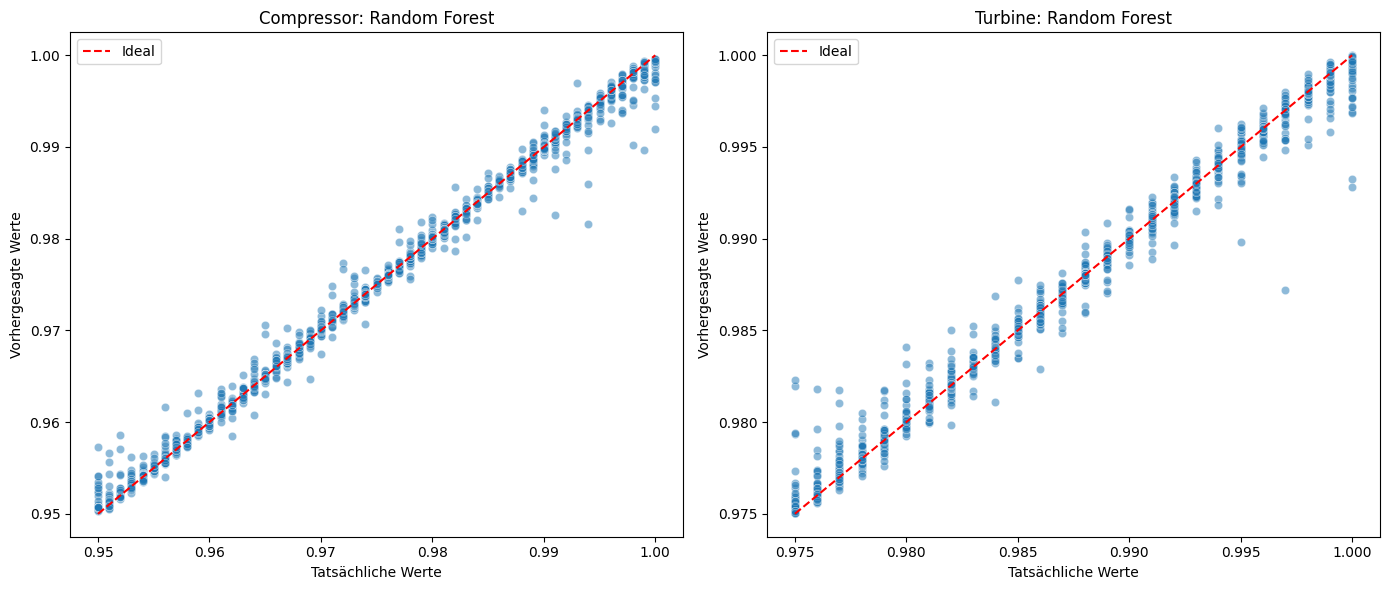

In [8]:
# Visualisierung tatsächlich vs vorhergesagte Werte

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, target_name in enumerate(targets.keys()):
    # Finde den Namen des besten Modells aus dem DataFrame
    target_results_df = results_df[results_df['Target'] == target_name]
    best_model_row = target_results_df.loc[target_results_df['R2'].idxmax()]
    best_model_name = best_model_row['Model']

    # Erstelle den Dateipfad und lade das Modell
    model_filename = f"{best_model_name.replace(' ', '_').lower()}_{target_name}_best_model.pkl"
    with open(f"../data/models/{model_filename}", 'rb') as f:
        best_model = pickle.load(f)

    # Erstelle Vorhersagen mit dem geladenen Modell
    predictions = best_model.predict(features_test)
    
    # Plotten
    ax = axes[i]
    sns.scatterplot(x=targets[target_name]["test"], y=predictions, alpha=0.5, ax=ax)
    ax.plot([targets[target_name]["test"].min(), targets[target_name]["test"].max()], 
             [targets[target_name]["test"].min(), targets[target_name]["test"].max()], 'r--', label='Ideal')
    ax.set_title(f'{target_name.capitalize()}: {best_model_name}')
    ax.set_xlabel('Tatsächliche Werte')
    ax.set_ylabel('Vorhergesagte Werte')
    ax.legend()

plt.tight_layout()